<a href="https://colab.research.google.com/github/viswambhar-yasa/AuToDiFf/blob/main/Solving_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This script validates the proposed method by solving a small differential equation whose solution is given by the variable seperable method.

The differential equation:
y' = y
BCs:
y(2) = exp(2)
y(3) = exp(3)

Strategy: 
-> the sampler is seeded and plotting is done only for the trained data points.
-> one training step means one descent step taken by calculating loss at all points one after another.
Type: Soft assignment of Boundary Conditions(deep galerkin approach)

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

!git clone https://github.com/viswambhar-yasa/AuToDiFf "/content/drive/My Drive/AutoDiff"

Mounted at /content/drive
fatal: destination path '/content/drive/My Drive/AutoDiff' already exists and is not an empty directory.


In [2]:
ls

drive/  sample_data/


In [3]:
import sys,os
sys.path.append('/content/drive/MyDrive/AutoDiff/')

In [4]:
ls

drive/  sample_data/


In [5]:
cd /content/drive/MyDrive/AutoDiff/

/content/drive/MyDrive/AutoDiff


In [6]:
import autodiff as ad 
import numpy as np
from NN_architecture import NeuralNetLSTM,xavier,diff_n_times
import matplotlib.pyplot as plt 
from optimizers import *

In [7]:

def loss_domain(model,point):
    """
    Calculates the loss within the domain of the differential equation
    inputs:
    model: The Neural Network model to be trained
    point: The point at which loss should be calculated(should lie within the domain)
    returns: Squared loss in domain
    """
    point = ad.Variable(np.array([[point]]),name="point")
    
    val = model.output(point)
    loss =    ad.grad(val,[point])[0] - val
    #print("loss:",loss())
    return ad.Pow(loss,2)
def loss_boundary(model):
    """
    Calculates loss at the boundaries.
    Inputs:
    model: The Neural Network model to be trained
    returns: Sum of Squared loss at the upper and lower boundaries
    """
    #point = ad.Variable(np.array([[0]]),name="point")
    pointu =ad.Variable(np.array([[2]]),name="pointu")
    pointm =ad.Variable(np.array([[3]]),name="pointm")
    #val = model.output(point)-np.array([[1]])
    valu =model.output(pointu)-np.array([[np.exp(2)]])
    valm = model.output(pointm)-np.array([[np.exp(3)]])


    return ad.Pow(valu+valm,2)
def sampler(n):
    """
    samples of random data points(uniformly distributed)
    inputs:
    n : number of data points

    returns array of size n  
    
    """
    np.random.seed(0)
    return np.random.uniform(2,3,n) 
#Instantiating the NN
model = NeuralNetLSTM(10,1,1,1)
model.set_weights([xavier(i().shape[0],i().shape[1]) for i in model.get_weights()])
loss = loss_domain(model,5)
print(loss())

[[24.92235489]]


In [11]:
resampler_epochs=[0]
for k in resampler_epochs:
    print("sampling for iteration:",k)
    listx= sampler(250)
    epochs = 100
    #Instantiating the optimizer
    optimizer = Adam(len(model.get_weights()),lr=0.0005)

    for j in range(epochs):
        L1 = ad.Variable(0,"L1")
        for i in listx:
            L1.value = L1.value + loss_domain(model,i)()[0][0] + loss_boundary(model)()[0][0]
        L1.value = L1.value /250
        print("initial loss",L1())
        
        for i in listx:
            params = model.get_weights()
            #Get gradients

            grad_params = ad.grad(loss_domain(model,i)+loss_boundary(model),params)
            new_params=[0 for _ in params]
            new_params = optimizer([i() for i in params], [i() for i in grad_params])
            model.set_weights(new_params)

        L2 = ad.Variable(0,"L2")
        for i in listx:
            L2.value = L2.value + loss_domain(model,i)()[0][0] + loss_boundary(model)()[0][0]
        L2.value = L2.value/250
        print("Now,loss:",L2())
        #Exit condition
        if L2() > L1() or L2() < 1e-2 or np.abs(L2()-L1()) < 1e-2:
            print("loss minimized:",L2())
            break
        else:
            print("gradient steptaken epoch:",j)

sampling for iteration: 0
initial loss 1177.9100854202613
Now,loss: 194.03959552418
gradient steptaken epoch: 0
initial loss 194.03959552418
Now,loss: 98.70916428597327
gradient steptaken epoch: 1
initial loss 98.70916428597327
Now,loss: 56.89711854599842
gradient steptaken epoch: 2
initial loss 56.89711854599842
Now,loss: 34.20477250271631
gradient steptaken epoch: 3
initial loss 34.20477250271631
Now,loss: 23.640489995367748
gradient steptaken epoch: 4
initial loss 23.640489995367748
Now,loss: 14.732343354272595
gradient steptaken epoch: 5
initial loss 14.732343354272595
Now,loss: 9.147111629995194
gradient steptaken epoch: 6
initial loss 9.147111629995194
Now,loss: 5.359437545645846
gradient steptaken epoch: 7
initial loss 5.359437545645846
Now,loss: 3.288123267964646
gradient steptaken epoch: 8
initial loss 3.288123267964646
Now,loss: 2.2392386203308194
gradient steptaken epoch: 9
initial loss 2.2392386203308194
Now,loss: 1.520332761670339
gradient steptaken epoch: 10
initial loss 

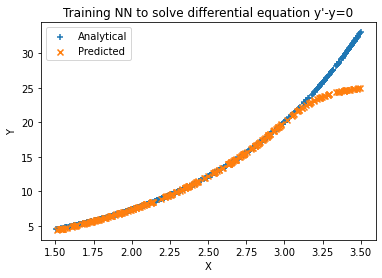

In [12]:
np.random.seed(0)
x_list = np.random.uniform(low=1.5,high=3.5,size=250)
plot_list = np.random.uniform(low=1.5,high=3.5,size=500)
def y(x):
    return np.exp(x)
y_list =[]
for i in x_list:
    X=ad.Variable(np.array([[i]]),name="X")
    Xm=ad.Variable(np.array([[1-i]]),name="Xm")
    val =model.output(X) 
    y_list.append(val()[0][0])
plt.scatter(plot_list,y(plot_list),marker="+",label="Analytical")
plt.scatter(x_list,y_list,marker="x",label="Predicted")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Training NN to solve differential equation y'-y=0")
plt.legend()
plt.show()